In [1]:
from google.colab import drive

import time

drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
from pyspark.sql.functions import avg, year, lag, col
from pyspark.sql.window import Window

In [2]:
#Instalar as dependências

#Instalar Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Realizar o download do Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

#Descompartar o arquivo baixado
!tar xf spark-3.4.0-bin-hadoop3.tgz

#Instalando a findspark
!pip install -q findspark

In [3]:
#Configurar as variáveis de ambiente

#Importando a biblioteca os
import os

#Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

#Importando a findspark
import findspark

#Iniciando o findspark
findspark.init('spark-3.4.0-bin-hadoop3')

In [4]:
# iniciar uma sessão local
from pyspark.sql import SparkSession

import time
from pyspark.sql.functions import *
sc = SparkSession.builder.master('local[*]').config('spark.ui.port', '4050').getOrCreate()

In [5]:
sc

In [6]:
# Iniciar contagem de tempo
start_time = time.time()

df = sc.read.csv("/content/drive/MyDrive/arquivo_carga", sep=';', header=True)

# Calcular o tempo de carregamento

end_time = time.time()
total_time = end_time - start_time

# Imprimir o tempo de carregamento
print("Tempo de carregamento utilizando Spark : %.2f segundos" % total_time)


Tempo de carregamento utilizando Spark : 10.76 segundos


In [7]:
df.createOrReplaceTempView("temp_table")
df_base = sc.sql("SELECT  TO_DATE( `Data da Coleta`, 'dd/MM/yyyy' ) AS data, `Regiao - Sigla` regiao,`Estado - Sigla` uf,`municipio`,`Bandeira` bandeira,`CNPJ da Revenda` cnpj,`produto` produto, CAST(REPLACE(`Valor de Venda`, ',', '.') AS FLOAT) venda FROM temp_table")
#df_base

In [8]:
# Extrair o ano da coluna de data
df_base = df_base.withColumn("Ano", year(df_base["Data"]))

# Obter os anos distintos em ordem decrescente
anos_distintos = df_base.select("Ano").distinct().orderBy("Ano", ascending=False)

# Exibir os anos distintos em ordem decrescente
anos_distintos.show()

+----+
| Ano|
+----+
|2022|
|2021|
|2020|
|2019|
|2018|
|2017|
|2016|
|2015|
|2014|
|2013|
|2012|
|2011|
|2010|
|2009|
|2008|
|2007|
|2006|
|2005|
|2004|
|null|
+----+



In [9]:
df_base.count()

22214364

In [10]:
df_base.show()

+----------+------+---+-------------+--------------------+-------------------+--------+-----+----+
|      data|regiao| uf|    municipio|            bandeira|               cnpj| produto|venda| Ano|
+----------+------+---+-------------+--------------------+-------------------+--------+-----+----+
|2004-07-01|    CO| MS| CAMPO GRANDE|            LIQUIGÁS| 86.807.609/0001-92|GASOLINA| 2.71|2004|
|2004-07-01|    CO| MS| CAMPO GRANDE|            LIQUIGÁS| 86.807.609/0001-92|  ETANOL| 1.71|2004|
|2004-07-01|    CO| MS| CAMPO GRANDE|            LIQUIGÁS| 86.807.609/0001-92|  DIESEL| 1.88|2004|
|2004-07-01|    CO| MT|ALTA FLORESTA|                CBPI| 04.481.758/0001-40|GASOLINA| 2.69|2004|
|2004-07-01|    CO| MT|ALTA FLORESTA|                CBPI| 04.481.758/0001-40|  ETANOL| 1.69|2004|
|2004-07-01|    CO| MT|ALTA FLORESTA|                CBPI| 04.481.758/0001-40|  DIESEL| 1.88|2004|
|2004-07-01|    CO| MT|ALTA FLORESTA|PETROBRAS DISTRIB...| 36.947.737/0005-97|GASOLINA| 2.66|2004|
|2004-07-0

In [12]:
df_base.write.mode('overwrite').parquet("/content/drive/MyDrive/Silver")

In [16]:
# Iniciar contagem de tempo
start_time = time.time()

df = sc.read.parquet("/content/drive/MyDrive/Silver")

# Calcular o tempo de carregamento

end_time = time.time()
total_time = end_time - start_time

# Imprimir o tempo de carregamento
print("Tempo de carregamento utilizando Spark : %.2f segundos" % total_time)

Tempo de carregamento utilizando Spark : 0.30 segundos


In [15]:
# Extrair o ano da coluna de data
df = df.withColumn("Ano", year(df["Data"]))

# Obter os anos distintos em ordem decrescente
anos_distintos = df.select("Ano").distinct().orderBy("Ano", ascending=False)

# Exibir os anos distintos em ordem decrescente
anos_distintos.show()

+----+
| Ano|
+----+
|2022|
|2021|
|2020|
|2019|
|2018|
|2017|
|2016|
|2015|
|2014|
|2013|
|2012|
|2011|
|2010|
|2009|
|2008|
|2007|
|2006|
|2005|
|2004|
|null|
+----+



In [17]:
df.count()

22214364

In [20]:
# Converter a coluna de data para o formato adequado
df_base = df.withColumn("Data", to_date(df["Data"], "yyyy-MM-dd"))

# Agrupar por ano e calcular a média de venda
df_media_venda = df_base.groupBy(year("Data").alias("Ano")).agg(avg("Venda").alias("Media_Venda"))

# Definir a janela para cálculo da variação
window = Window.orderBy("Ano")

# Calcular a variação da média de um ano para o outro
df_variacao_media = df_media_venda.withColumn("Variacao_Media", (col("Media_Venda") - lag("Media_Venda").over(window))/lag("Media_Venda").over(window))

# Criar o novo DataFrame com as colunas desejadas
df_novo = df_media_venda.join(df_variacao_media.select("Ano", "Variacao_Media"), "Ano")

# Exibir o novo DataFrame
df_novo.show()


+----+------------------+--------------------+
| Ano|       Media_Venda|      Variacao_Media|
+----+------------------+--------------------+
|2004|1.6563659175960408|                null|
|2005|1.8634834937942792| 0.12504336994499235|
|2006| 2.093136501441693| 0.12323855210534343|
|2007|2.0158640836249244|-0.03691704662526571|
|2008|2.0554615955550166| 0.01964294728585471|
|2009| 2.072870593263671|0.008469629277580186|
|2010|2.1315607692353287| 0.02831347801564965|
|2011|2.3002933665717396|  0.0791591775246181|
|2012|2.3164652473682037| 0.00703035579351604|
|2013| 2.453077668679573|0.058974517949957686|
|2014| 2.599521068503893|0.059697824367357516|
|2015|  2.87150763110094| 0.10462948959809129|
|2016|  3.20498244723821| 0.11613231061113874|
|2017|3.2638906882811414|0.018380207072177215|
|2018| 3.702544911961598| 0.13439611358781883|
|2019| 3.748455502945497|0.012399739118782482|
|2020| 3.654332247518224|-0.02510987668209...|
|2021| 5.237571511571185|  0.4332499501456637|
|2022|  6.117

In [23]:
# Converter a coluna de data para o formato adequado
df_base = df.withColumn("Data", to_date(df["Data"], "yyyy-MM-dd"))

# Filtrar os produtos desejados ('GNV', 'GASOLINA', 'ETANOL' e 'DIESEL')
produtos_desejados = ['GNV', 'GASOLINA', 'ETANOL', 'DIESEL']
df_filtrado = df_base.filter(col("produto").isin(produtos_desejados))

# Agrupar por ano e produto, e calcular a média de venda
df_media_venda = df_filtrado.groupBy(year("Data").alias("Ano"), "produto").agg(avg("Venda").alias("Media_Venda"))

# Definir a janela para cálculo da variação
window = Window.partitionBy("produto").orderBy("Ano")

# Calcular a variação da média de um ano para o outro para cada produto
df_variacao_media = df_media_venda.withColumn("Variacao_Media", (col("Media_Venda") - lag("Media_Venda").over(window)) / lag("Media_Venda").over(window))

# Criar o novo DataFrame com as colunas desejadas
df_novo = df_media_venda.join(df_variacao_media.select("Ano", "produto", "Variacao_Media"), ["Ano", "produto"])

# Exibir o novo DataFrame
df_novo.show(5)

+----+-------+------------------+--------------------+
| Ano|produto|       Media_Venda|      Variacao_Media|
+----+-------+------------------+--------------------+
|2004| DIESEL| 1.516346262912861|                null|
|2005| DIESEL| 1.741076957305779|  0.1482053933784334|
|2006| DIESEL| 1.882685265054555| 0.08133374412576631|
|2007| DIESEL| 1.875401705769709|-0.00386870786107...|
|2008| DIESEL|2.0358318128436492| 0.08554439647803132|
+----+-------+------------------+--------------------+
only showing top 5 rows



In [24]:
import pandas as pd

# Converter o DataFrame Spark para Pandas DataFrame
df_pandas = df_novo.toPandas()


<ipython-input-25-de79af54d40a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produto['Ano'] = df_produto['Ano'].astype(int).astype(str).str[:4]  # Converter para string com 4 primeiros dígitos


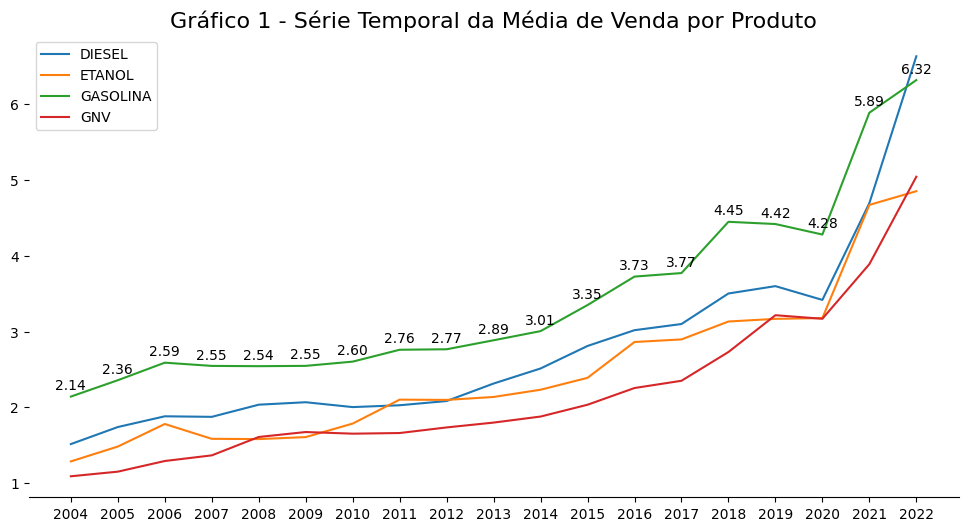

In [25]:
import matplotlib.pyplot as plt

# Criar uma figura e um eixo com tamanho personalizado
fig, ax = plt.subplots(figsize=(12, 6))  # Definir a largura (12) e altura (6) da figura

# Iterar pelos produtos únicos e plotar as séries temporais com cores diferentes
for produto in df_pandas['produto'].unique():
    df_produto = df_pandas[df_pandas['produto'] == produto]
    df_produto['Ano'] = df_produto['Ano'].astype(int).astype(str).str[:4]  # Converter para string com 4 primeiros dígitos

    if produto == 'GASOLINA':
        ax.plot(df_produto['Ano'], df_produto['Media_Venda'], label=produto)

        # Adicionar rótulos aos pontos de dados
        for i, (ano, media_venda) in enumerate(zip(df_produto['Ano'], df_produto['Media_Venda'])):
            ax.annotate(f'{media_venda:.2f}', (ano, media_venda), textcoords="offset points", xytext=(0,5), ha='center')
    else:
        ax.plot(df_produto['Ano'], df_produto['Media_Venda'], label=produto)

# Configurar o título e as legendas
ax.set_title('Gráfico 1 - Série Temporal da Média de Venda por Produto',fontsize=16)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Exibir o gráfico
plt.show()

In [26]:
# Filtrar as linhas com data_coleta maior que 2019
df_filtered = df_base.filter(df_base.Data >= '2022-01-01')

In [27]:
import pyspark.sql.functions as F

# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats = df_filtered.groupBy('municipio').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas = df_stats.toPandas()


In [28]:
df_pandas.sort_values(by='mean', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
63,CRUZEIRO DO SUL,7.615234,6.83,7.77,8.30,0.793189
438,TEFE,7.541550,7.25,7.59,7.95,0.607534
378,PARINTINS,7.388192,6.99,7.59,7.77,0.645088
225,ALENQUER,7.383711,6.99,7.54,7.99,0.780035
55,CONCEICAO DO ARAGUAIA,7.297287,6.75,7.44,7.95,0.759252


In [29]:
df_pandas.sort_values(by='std_dev', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
394,PRESIDENTE PRUDENTE,5.609861,4.63,5.64,6.89,1.357607
215,VARZEA GRANDE,5.623938,4.69,5.79,6.77,1.332096
297,GOIANIA,5.897455,4.94,5.84,6.99,1.317070
230,ANAPOLIS,5.800154,4.79,5.87,6.94,1.315283
366,NOVA LIMA,5.838592,4.97,5.59,6.99,1.314492


In [30]:
# Todos os anos
df_filtered2 = df_base


# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats2 = df_filtered2.groupBy('municipio').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas2 = df_stats2.toPandas()

In [31]:
df_pandas2.sort_values(by='mean', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
492,JAPARATUBA,6.118889,5.540,6.180,6.490,0.866421
603,ROSARIO DO SUL,5.653919,4.700,5.896,6.179,0.849231
333,ANAMA,4.225630,4.070,4.199,4.290,0.354479
684,VARGEAO,4.079000,3.699,3.999,4.499,0.402492
100,CRUZEIRO DO SUL,3.980824,2.840,3.450,4.690,1.461675


In [32]:
df_pandas2.sort_values(by='std_dev', ascending=False).head(5)

,municipio,mean,q1,median,q3,std_dev
528,MESQUITA,3.560860,1.699,2.429,5.59,2.162487
326,ALENQUER,3.745283,2.550,3.150,4.40,1.578873
426,DELMIRO GOUVEIA,3.433583,2.380,3.070,4.04,1.468211
100,CRUZEIRO DO SUL,3.980824,2.840,3.450,4.69,1.461675
574,PETROPOLIS,2.991945,1.969,2.640,3.59,1.429025


In [48]:
df_filtered.show(5)

+----------+------+---+---------+-------------+-------------------+------------------+-----+----+
|      Data|regiao| uf|municipio|     bandeira|               cnpj|           produto|venda| Ano|
+----------+------+---+---------+-------------+-------------------+------------------+-----+----+
|2022-07-01|    SE| ES| COLATINA|VIBRA ENERGIA| 08.519.545/0001-10|GASOLINA ADITIVADA| 7.48|2022|
|2022-07-01|    SE| ES| COLATINA|VIBRA ENERGIA| 08.519.545/0001-10|          GASOLINA| 7.38|2022|
|2022-07-01|    SE| ES| COLATINA|VIBRA ENERGIA| 04.814.652/0001-10|        DIESEL S10| 7.69|2022|
|2022-07-01|    SE| ES| COLATINA|VIBRA ENERGIA| 04.814.652/0001-10|            ETANOL| 5.99|2022|
|2022-07-01|    SE| ES| COLATINA|VIBRA ENERGIA| 04.814.652/0001-10|          GASOLINA| 7.39|2022|
+----------+------+---+---------+-------------+-------------------+------------------+-----+----+
only showing top 5 rows



In [53]:
# AGRUPAR POR REGIAO GEOGRAFICA, gasolina e ano = 2022

df_base = df.withColumn("Data", to_date(df["Data"], "yyyy-MM-dd"))

# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade, filtrando apenas o produto "gasolina"
df_stats = df_filtered.filter((df_filtered.produto == 'GASOLINA') & (df_filtered.Ano == '2022')).groupBy('regiao').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas3 = df_stats.toPandas()

In [54]:
df_pandas3.sort_values(by='mean', ascending=False).head(5)


,regiao,mean,q1,median,q3,std_dev
0,NE,6.554897,5.64,6.78,7.33,1.000900
1,N,6.457659,5.49,6.69,7.29,1.004298
4,CO,6.336670,5.34,6.59,7.15,0.999319
3,SE,6.242079,5.29,6.39,6.99,0.995302
2,S,6.194835,5.39,6.39,6.96,0.885276


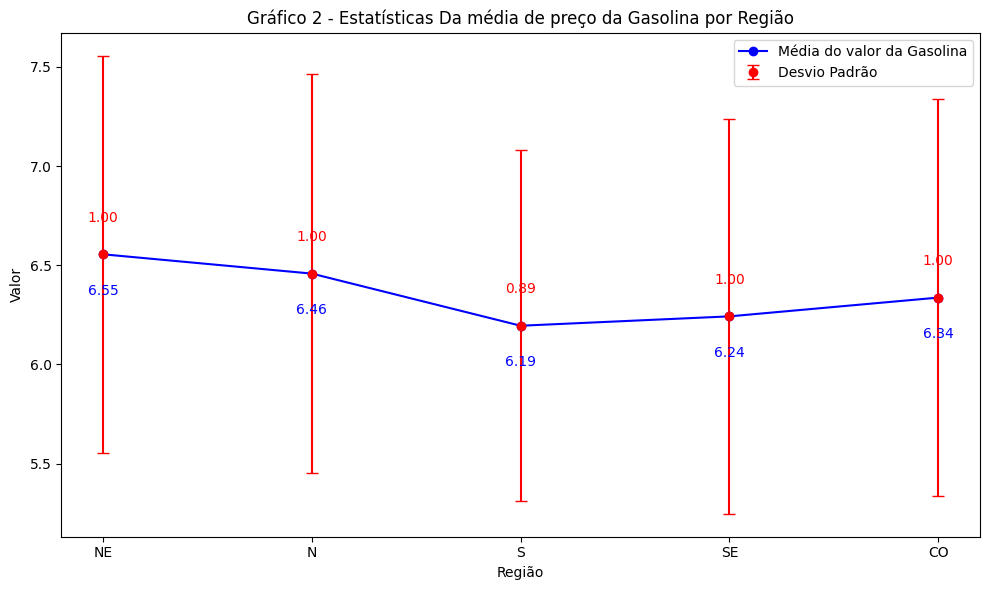

In [66]:
# Configurar o gráfico
plt.figure(figsize=(10, 6)) # Tamanho da figura
plt.errorbar(df_pandas3['regiao'], df_pandas3['mean'], yerr=df_pandas3['std_dev'], fmt='o', color='red', capsize=4, label='Desvio Padrão')
plt.plot(df_pandas3['regiao'], df_pandas3['mean'], linestyle='-', marker='o', color='blue', label='Média do valor da Gasolina')

# Adicionar rótulos dos valores do desvio padrão
for i in range(len(df_pandas3)):
    plt.text(df_pandas3['regiao'][i], df_pandas3['mean'][i]+0.15, f"{df_pandas3['std_dev'][i]:.2f}", ha='center', va='bottom', color='red')

# Adicionar rótulos dos valores da média
for i in range(len(df_pandas3)):
    plt.text(df_pandas3['regiao'][i], df_pandas3['mean'][i] - 0.15, f"{df_pandas3['mean'][i]:.2f}", ha='center', va='top', color='blue')



# Títulos e legendas
plt.title('Gráfico 2 - Estatísticas Da média de preço da Gasolina por Região')
plt.xlabel('Região')
plt.ylabel('Valor')
plt.legend()

# Ajustar layout para melhor visibilidade dos rótulos
plt.tight_layout()



# Exibir o gráfico
plt.show()
fig.savefig('esta.png')




In [36]:
# AGRUPAR POR ESTADO

# Calcular estatísticas descritivas da coluna valor_venda agrupado por cidade
df_stats = df_filtered.groupBy('uf').agg(
    F.mean('venda').alias('mean'),
    F.expr('percentile_approx(venda, 0.25)').alias('q1'),
    F.expr('percentile_approx(venda, 0.5)').alias('median'),
    F.expr('percentile_approx(venda, 0.75)').alias('q3'),
    F.stddev('venda').alias('std_dev')
)

# Converter o DataFrame do Spark para um DataFrame do pandas
df_pandas4 = df_stats.toPandas()

In [37]:
df_pandas4.sort_values(by='mean', ascending=False).head(100)


,uf,mean,q1,median,q3,std_dev
23,AC,7.006290,6.24,7.29,7.67,0.963129
15,PA,6.678565,5.97,6.89,7.43,0.990948
1,RO,6.659422,5.90,6.88,7.39,0.900727
4,RR,6.532472,5.84,6.79,7.16,0.836104
2,PI,6.523207,5.59,6.79,7.49,1.172352
16,BA,6.509285,5.66,6.66,7.39,1.105841
22,MA,6.434475,5.68,6.69,7.19,0.978499
19,CE,6.434005,5.67,6.51,7.29,1.050578
20,RN,6.421326,5.59,6.59,7.29,1.047280
6,TO,6.350114,5.60,6.49,7.09,0.936593
